In [46]:
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


# === 1. IMDb Filmleri ve Dizileri Yükle ===
movies = pd.read_csv("./Datasets/IMDb movies.csv")
series = pd.read_csv("./Datasets/IMDb TV series.csv")

# === 1.1 Rating kolonlarını hizala
movies['rating'] = movies['avg_vote']  # avg_vote → rating
# series zaten 'rating' içeriyor (doğrudan kullanılabilir)
movies.drop(columns=['avg_vote'], inplace=True, errors='ignore')  # Eski kolon silinir (varsa)

# === 2. Kaynak Türünü Belirt
movies['type'] = 'movie'
series['type'] = 'tv_series'

# === 3. Ortak Kolonlara Göre Birleştir
common_cols = list(set(movies.columns).intersection(set(series.columns)))
imdb = pd.concat([movies[common_cols], series[common_cols]], ignore_index=True)

# === 4. Genel Temizleme Fonksiyonu (özel karakterleri kaldırır)
def clean_text(text):
    if pd.notnull(text):
        text = text.lower()
        text = re.sub(r'[^\w\s]', '', text)  # harf ve sayılar dışındaki her şeyi kaldır
        text = re.sub(r'\s+', ' ', text)     # fazla boşlukları tek boşluğa indir
        return text.strip()
    return ""

# === 5. Kolonları Temizle
imdb['title'] = imdb['title'].apply(clean_text)
imdb['genre'] = imdb['genre'].apply(clean_text)
imdb['description'] = imdb['description'].apply(clean_text)

# === 5.1 Type Kolonunu Düzenle (tv_series → tv show)
imdb['type'] = imdb['type'].str.lower().str.strip().replace({'tv_series': 'tv show', 'movie': 'movie'})

# === 6. Yıl Formatı Temizliği
imdb['year'] = imdb['year'].astype(str).str.extract(r'(\d{4})')
imdb['year'] = pd.to_numeric(imdb['year'], errors='coerce').fillna(0).astype(int)

# === 7. CSV Olarak Kaydet
output_path = "./preprocessed_datasets/cleaned_imdb_combined.csv"
imdb.to_csv(output_path, index=False)
print("✅ IMDb verisi başarıyla kaydedildi:", output_path)

# ✅ Son 5 satırı göster
imdb.head(5)

OSError: Cannot save file into a non-existent directory: 'preprocessed_datasets'

In [32]:
# === 1. Dosyaları Yükle ===
netflix = pd.read_csv("./Datasets/netflix_titles.csv")
amazon = pd.read_csv("./Datasets/amazon_prime_titles.csv")
disney = pd.read_csv("./Datasets/disney_plus_titles.csv")

# === 2. Platform Bilgisi Ekle ===
netflix['platform'] = 'netflix'
amazon['platform'] = 'amazon'
disney['platform'] = 'disney'

# === 3. Tür Bilgisini Normalize Et
netflix['type'] = netflix['type'].str.lower().str.strip()
amazon['type'] = amazon['type'].str.lower().str.strip()
disney['type'] = disney['type'].str.lower().str.strip()

# === 4. Ortak Kolonlara Göre Birleştir
common_cols = list(set(netflix.columns) & set(amazon.columns) & set(disney.columns))
platforms = pd.concat([
    netflix[common_cols],
    amazon[common_cols],
    disney[common_cols]
], ignore_index=True)

# === 5. Temizleme
platforms['title'] = platforms['title'].str.lower().str.strip()
platforms['title'] = platforms['title'].apply(lambda x: re.sub(r'[^\w\s]', '', x) if pd.notnull(x) else x)
platforms['cast'] = platforms['cast'].str.lower().str.strip()
platforms['listed_in'] = platforms['listed_in'].str.lower().str.strip()
platforms['description'] = platforms['description'].str.lower().str.strip()

# === 6. release_year → year
platforms.rename(columns={'release_year': 'year', 'listed_in': 'genre',  }, inplace=True)

# === 7. Gereksiz kolonları kaldır
platforms.drop(columns=['rating', 'cast', 'country', 'duration', 'show_id', 'director', 'date_added'],
               inplace=True, errors='ignore')

# === 8. Kaydet
output_path = "./processed_datasets/Netflix_Disney_Amazon.csv"
platforms.to_csv(output_path, index=False)
print("✅ Platform verisi başarıyla kaydedildi:", output_path)

# ✅ İlk 50 satırı göster
platforms.head(5)

✅ Platform verisi başarıyla kaydedildi: ./Netflix_Disney_Amazon.csv


,year,description,title,type,platform,genre
0,2020,"as her father nears the end of his life, filmm...",dick johnson is dead,movie,netflix,documentaries
1,2021,"after crossing paths at a party, a cape town t...",blood water,tv show,netflix,"international tv shows, tv dramas, tv mysteries"
2,2021,to protect his family from a powerful drug lor...,ganglands,tv show,netflix,"crime tv shows, international tv shows, tv act..."
3,2021,"feuds, flirtations and toilet talk go down amo...",jailbirds new orleans,tv show,netflix,"docuseries, reality tv"
4,2021,in a city of coaching centers known to train i...,kota factory,tv show,netflix,"international tv shows, romantic tv shows, tv ..."


In [44]:
# === 1. IMDb Verisini Yükle (temiz hali)
imdb = pd.read_csv("./processed_datasets/cleaned_imdb_combined.csv")

# === 2. Platform Verisini Yükle (temiz hali)
platforms = pd.read_csv("./processed_datasets/Netflix_Disney_Amazon.csv")

# === 3. Başlıkları normalize et (küçük harfe çevir + boşluk düzeltmeleri)
def normalize_title(text):
    if pd.notnull(text):
        text = text.lower().strip()
        text = re.sub(r'\s+', ' ', text)
        return text
    return ""

imdb['title'] = imdb['title'].apply(normalize_title)
platforms['title'] = platforms['title'].apply(normalize_title)

# === 4. Aynı başlıktaki platformları grupla
platform_mapping = platforms.groupby('title')['platform'].apply(lambda x: ', '.join(sorted(set(x)))).reset_index()

# === 5. IMDb'ye platform bilgisini ekle
imdb.drop(columns=['platform'], inplace=True, errors='ignore')
imdb = imdb.merge(platform_mapping, on='title', how='left')
imdb['platform'] = imdb['platform'].fillna("np")
# === 5.1 Platform bilgisine göre binary etiket oluştur
imdb['platform_flag'] = imdb['platform'].apply(lambda x: 0 if x == 'np' else 1)

# ➖ Eksik açıklama, rating ve süre verilerini çıkar
imdb = imdb[imdb['description'].notna()]
imdb = imdb[imdb['description'].str.strip() != ""]
imdb = imdb[imdb['rating'].notna()]
imdb = imdb[imdb['duration'].notna()]

# === 6. Kaydet
output_path = "./imdb_with_platforms.csv"
imdb.to_csv(output_path, index=False)
print("✅ IMDb + Platform verisi başarıyla birleştirildi ve NaN satırlar atıldı:", output_path)

# ✅ Kontrol
print(imdb[['title', 'platform']].head(5))

FileNotFoundError: [Errno 2] No such file or directory: './processed_datasets/cleaned_imdb_combined.csv'

In [34]:
# Votes sütununu sayıya çevir (örneğin: "1,234" → 1234)
imdb['votes'] = imdb['votes'].astype(str).str.replace(",", "").str.strip()
imdb['votes'] = pd.to_numeric(imdb['votes'], errors='coerce')

# Duration sütununu sayıya çevir (örneğin: "100 min" → 100)
imdb['duration'] = imdb['duration'].astype(str).str.extract(r'(\d+)')
imdb['duration'] = pd.to_numeric(imdb['duration'], errors='coerce')
imdb.to_csv(output_path, index=False)
imdb[['votes', 'duration']].dtypes

votes       int64
duration    int64
dtype: object

In [35]:
# Gereksiz sütunları kaldır
imdb.drop(columns=['type_binary', 'type_tv show'], inplace=True, errors='ignore')

# Orijinal 'type' sütunu yeniden eklendiyse veya varsa dönüştür
# Movie = 0, TV Show = 1
imdb['type'] = imdb['type'].str.lower().str.strip()
imdb['type'] = imdb['type'].apply(lambda x: 0 if x == 'movie' else 1)
# genre sütununu boşluğa göre parçala
genre_split = imdb['genre'].dropna().str.lower().str.split()

# benzersiz türleri topla
unique_genres = set()
for genres in genre_split:
    unique_genres.update(genres)

# her tür için binary sütun oluştur
for genre in unique_genres:
    imdb[f"genre_{genre}"] = imdb['genre'].astype(str).str.lower().apply(lambda x: int(genre in x.split()))
    
imdb.to_csv(output_path, index=False)
print (imdb)

                                             description  rating  \
0      true story of notorious australian outlaw ned ...     6.1   
1      two men of high rank are both wooing the beaut...     5.9   
2      the fabled queen of egypts affair with roman g...     5.2   
3      loosely adapted from dantes divine comedy and ...     7.0   
4      an account of the life of jesus christ based o...     5.7   
...                                                  ...     ...   
91225  after an experimental gene therapy turns them ...     6.3   
91226  sheriff deputy rick grimes wakes up from a com...     8.1   
91227  follows the political rivalries and romance of...     8.7   
91228  two brothers follow their fathers footsteps as...     8.4   
91229  when a psychiatrist shelters a mysterious cult...     5.9   

                                                   title  year  duration  \
0                            the story of the kelly gang  1906        70   
1                              

  Platform Group  Content Count
0      Avaliable          74390
1  Not Avaliable          12934


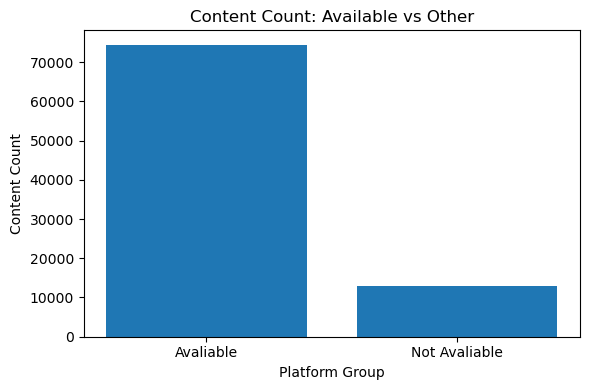

In [36]:

# 🚀 Platformları tekil hale getir (split + explode)
imdb_expanded = imdb.copy()
imdb_expanded['platform'] = imdb_expanded['platform'].fillna("np")
imdb_expanded['platform'] = imdb_expanded['platform'].apply(lambda x: [p.strip() for p in x.split(',')])
imdb_expanded = imdb_expanded.explode('platform')

# 🎯 3 ana platformu gruplandır: netflix, amazon, disney → 'available'
imdb_expanded['platform_group'] = imdb_expanded['platform'].apply(
    lambda x: 'Not Avaliable' if x in ['netflix', 'amazon', 'disney'] else 'Avaliable'
)

# 📊 Platform gruplarına göre say
platform_counts = imdb_expanded['platform_group'].value_counts().reset_index()
platform_counts.columns = ['Platform Group', 'Content Count']

# 🖨️ Tabloyu yazdır
print(platform_counts)

# 📈 Tek barlı grafik
plt.figure(figsize=(6, 4))
plt.bar(platform_counts['Platform Group'], platform_counts['Content Count'])
plt.title("Content Count: Available vs Other")
plt.xlabel("Platform Group")
plt.ylabel("Content Count")
plt.tight_layout()
plt.show()

In [37]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

# 📥 Veri setini yükle
imdb = pd.read_csv("imdb_with_platforms.csv")  # Yolun göreceli olduğuna emin ol

# 🧹 Eksik açıklamaları boş string ile doldur
descriptions = imdb['description'].fillna("")

# 🧠 TF-IDF vektörleştirici oluştur (İngilizce stopword'leri filtrele)
tfidf = TfidfVectorizer(stop_words='english', max_features=500)

# 🎯 TF-IDF matrisini oluştur
tfidf_matrix = tfidf.fit_transform(descriptions)

# 📊 Matristen DataFrame oluştur
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())

# ✅ Sonuç: tfidf_df, her satır bir film olacak şekilde TF-IDF değerlerini içerir
print(tfidf_df.head())

   abandoned  accident  accidentally  accused  action  actor  actress  \
0        0.0       0.0           0.0      0.0     0.0    0.0      0.0   
1        0.0       0.0           0.0      0.0     0.0    0.0      0.0   
2        0.0       0.0           0.0      0.0     0.0    0.0      0.0   
3        0.0       0.0           0.0      0.0     0.0    0.0      0.0   
4        0.0       0.0           0.0      0.0     0.0    0.0      0.0   

   adventure  adventures  affair  ...  working  works  world  writer  wrong  \
0        0.0         0.0     0.0  ...      0.0    0.0    0.0     0.0    0.0   
1        0.0         0.0     0.0  ...      0.0    0.0    0.0     0.0    0.0   
2        0.0         0.0     1.0  ...      0.0    0.0    0.0     0.0    0.0   
3        0.0         0.0     0.0  ...      0.0    0.0    0.0     0.0    0.0   
4        0.0         0.0     0.0  ...      0.0    0.0    0.0     0.0    0.0   

   year  years  york  young  younger  
0   0.0    0.0   0.0    0.0      0.0  
1   0.0 

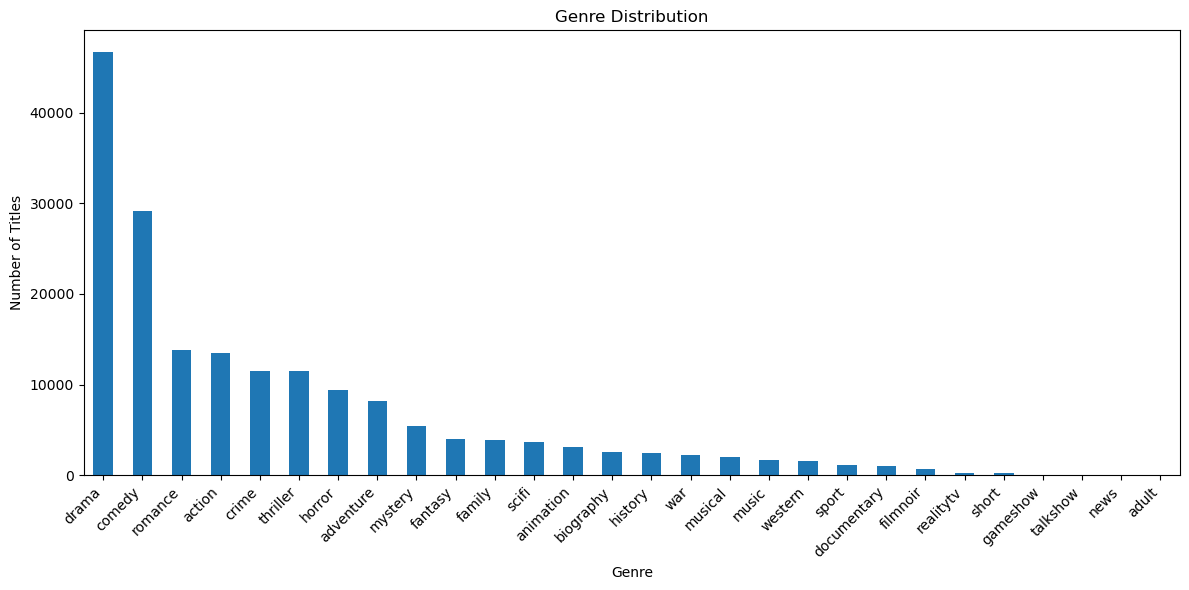

In [40]:
import pandas as pd
import matplotlib.pyplot as plt

# 📥 Veriyi yükle
imdb = pd.read_csv("./Datasets/imdb_with_platforms.csv")

# 🔍 Genre sütununu boş olmayanlardan al, boşluklardan ayır ve hepsini tek listeye dök
genres = imdb['genre'].dropna().apply(lambda x: x.lower().split())
all_genres = genres.explode()

# 📊 Türlerin frekansını hesapla
genre_counts = all_genres.value_counts()

# 📈 Bar grafik çiz
plt.figure(figsize=(12, 6))
genre_counts.plot(kind='bar')
plt.title("Genre Distribution")
plt.xlabel("Genre")
plt.ylabel("Number of Titles")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()